<a href="https://colab.research.google.com/github/Xistulino/Decision-Tree/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importar os pacotes

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [3]:
# Importar o banco de dados

dados = pd.read_csv("dados_carros.csv")
# Fonte: https://www.kaggle.com/datasets/gabrielsantello/cars-purchase-decision-dataset?select=car_data.csv

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [5]:
# Limpeza dos dados

# Remover colunas que não serão utilizadas
dados.drop(columns=['User ID'], inplace=True)

In [6]:
# Estatísticas descritivas das variáveis

# Variáveis métricas
print(dados[['Age','AnnualSalary']].describe())

# Variáveis categóricas
print(dados['Gender'].value_counts())
print(dados['Purchased'].value_counts())

               Age   AnnualSalary
count  1000.000000    1000.000000
mean     40.106000   72689.000000
std      10.707073   34488.341867
min      18.000000   15000.000000
25%      32.000000   46375.000000
50%      40.000000   72000.000000
75%      48.000000   90000.000000
max      63.000000  152500.000000
Gender
Female    516
Male      484
Name: count, dtype: int64
Purchased
0    598
1    402
Name: count, dtype: int64


In [7]:
# Transformando variáveis explicativas categóricas em dummies

dados = pd.get_dummies(dados,
                       columns=['Gender'],
                       drop_first=True,
                       dtype='int')

In [8]:
# Separando as variáveis Y e X

X = dados.drop(columns=['Purchased'])
y = dados['Purchased']


In [9]:
# Separando as amostras de treino e teste

# Vamos escolher 70% das observações para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=100)

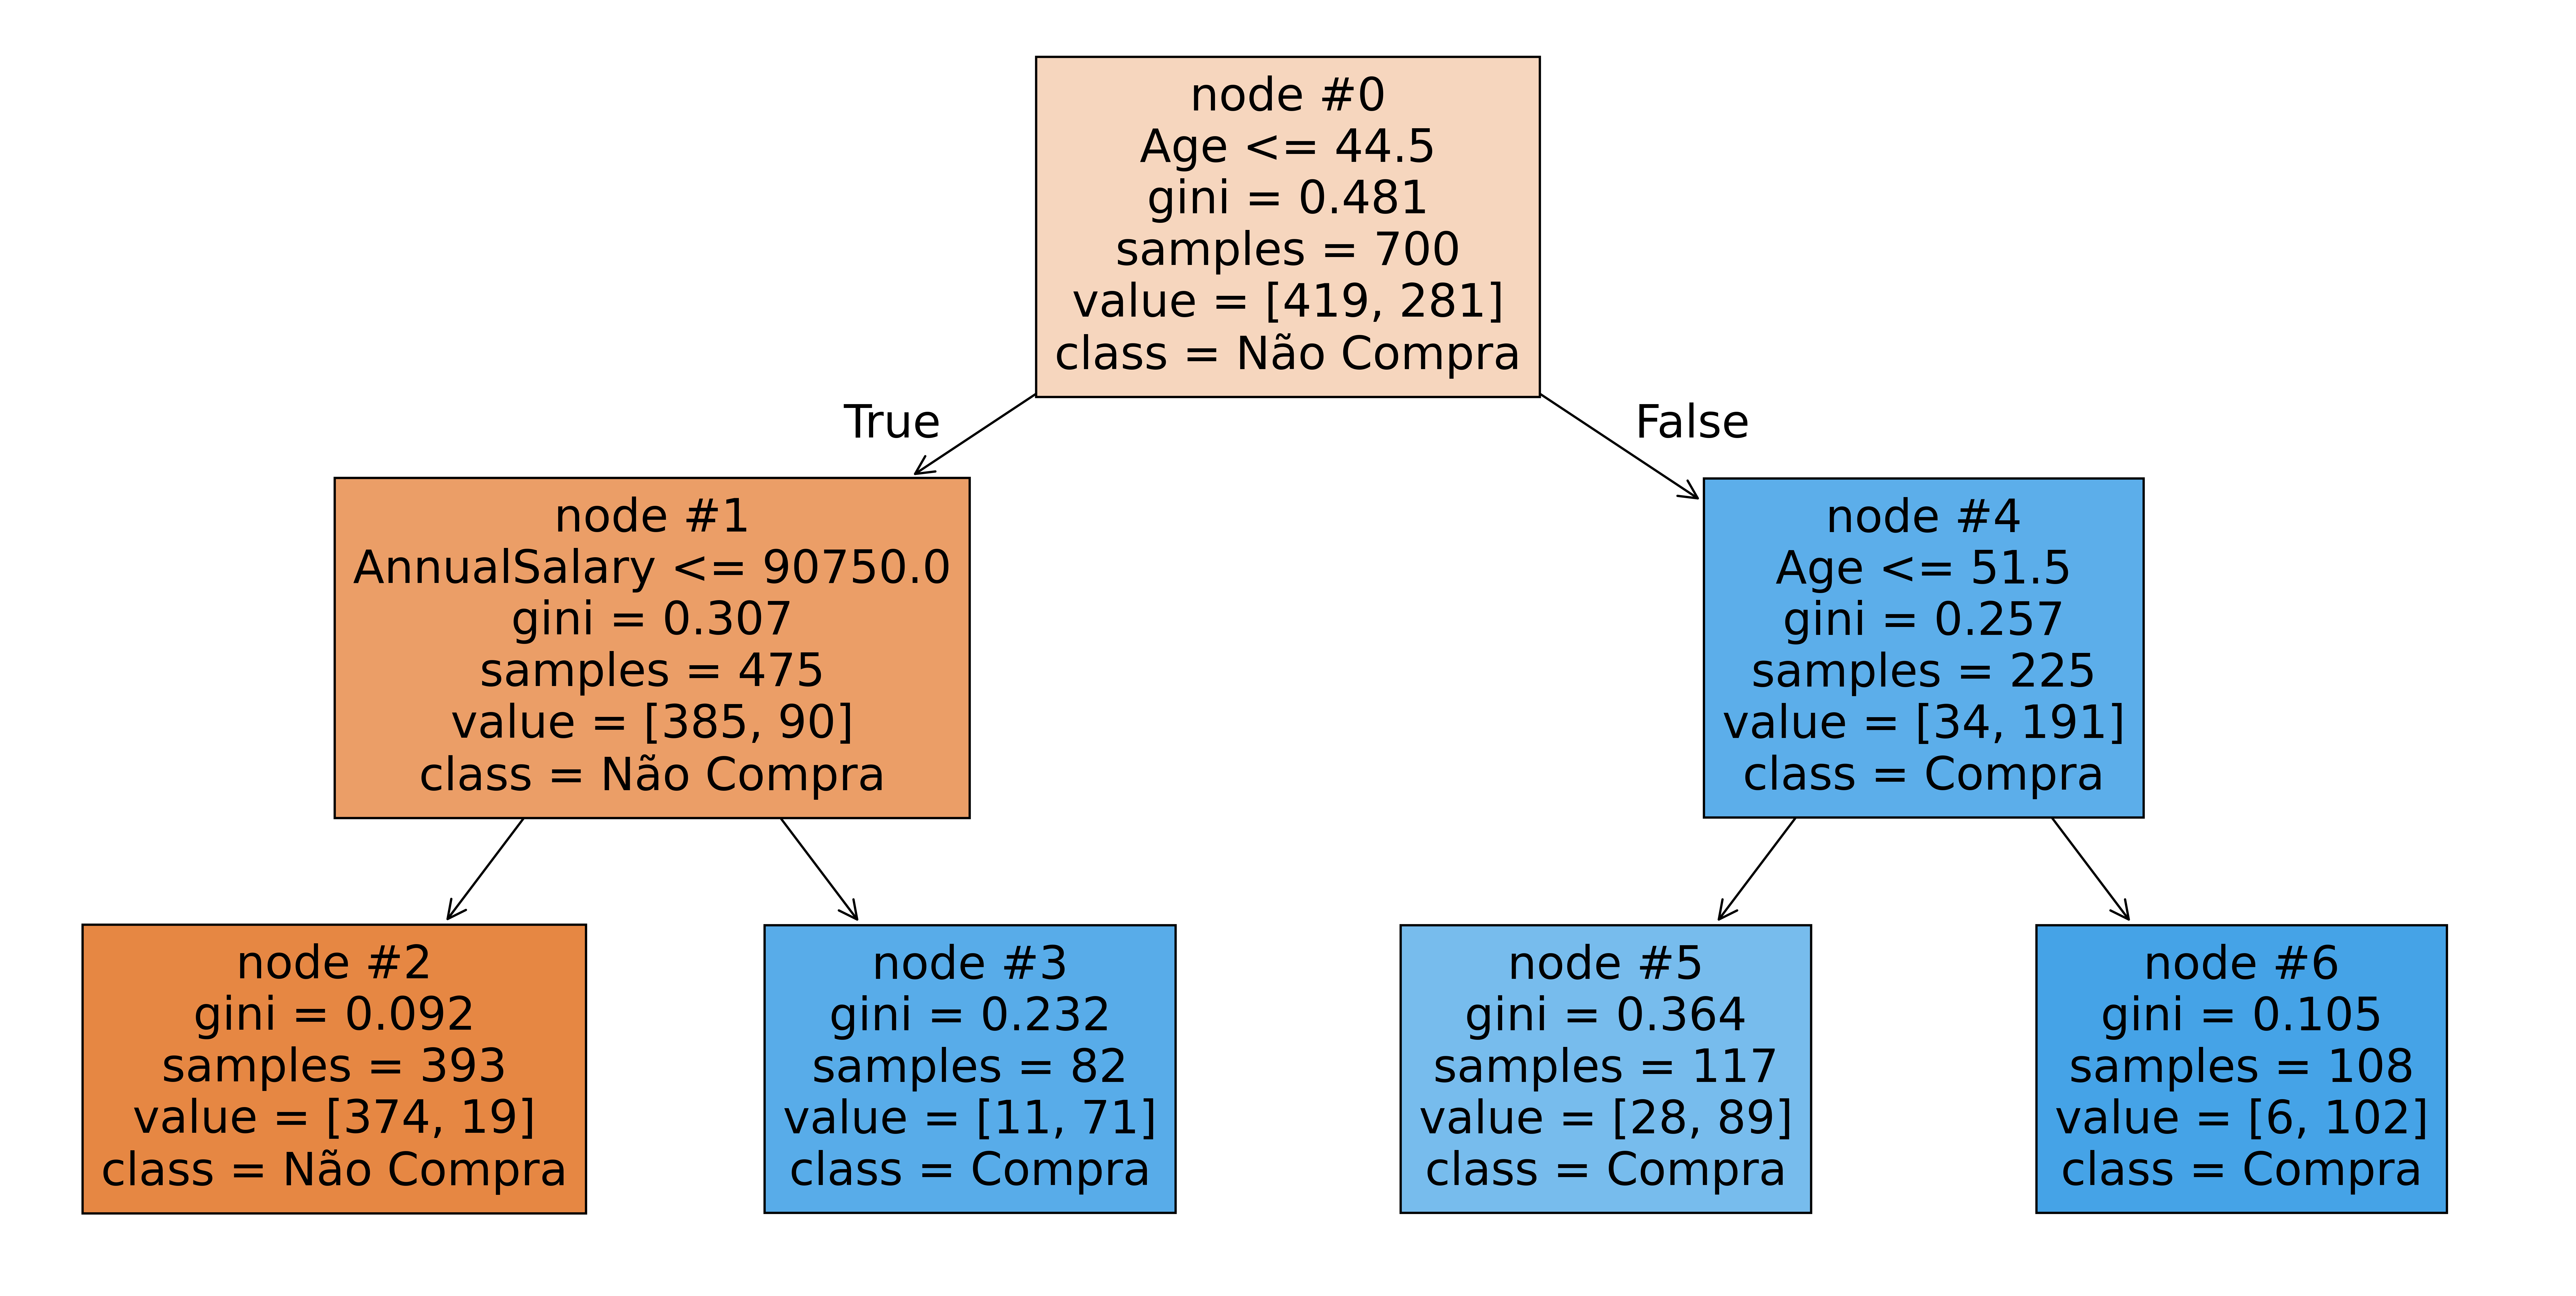

In [10]:
#%%######################### Árvore de Decisão ################################
###############################################################################
#%% Gerando a árvore de decisão

# Vamos iniciar com uma árvore pequena: profundidade máxima 2 (max_depth)
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=100)
tree_clf.fit(X_train, y_train)

#%% Plotando a árvore

plt.figure(figsize=(20,10), dpi=600)
plot_tree(tree_clf,
          feature_names=X.columns.tolist(),
          class_names=['Não Compra','Compra'],
          proportion=False,
          filled=True,
          node_ids=True)
plt.show()

Coeficiente de gini: O coeficiente de gini indica a impureza de um nó. Quanto mais próximo do zero estiver o gini, mais puro será o Nó.



In [11]:
# Analisando os resultados dos splits
#cost_complexity_pruning_path mostra a tabela das reduções do gini

tree_split = pd.DataFrame(tree_clf.cost_complexity_pruning_path(X_train, y_train))
tree_split.sort_index(ascending=False, inplace=True)

print(tree_split)


   ccp_alphas  impurities
3    0.189683    0.480567
2    0.129547    0.290885
1    0.005418    0.161337
0    0.000000    0.155919


In [12]:
# Importância das variáveis preditoras
#features e importance = mostra a importância das variáveis

tree_features = pd.DataFrame({'features':X.columns.tolist(),
                              'importance':tree_clf.feature_importances_})

print(tree_features)


       features  importance
0           Age    0.600961
1  AnnualSalary    0.399039
2   Gender_Male    0.000000


In [13]:
# Obtendo os valores preditos pela árvore

# Predict na base de treinamento
tree_pred_train_class = tree_clf.predict(X_train) #Retorna a classe prevista (0 ou 1, por exemplo) para cada amostra do conjunto de treino.
tree_pred_train_prob = tree_clf.predict_proba(X_train) #Retorna a probabilidade prevista de cada classe, como:

# Predict na base de testes
tree_pred_test_class = tree_clf.predict(X_test)
tree_pred_test_prob = tree_clf.predict_proba(X_test)

In [14]:
# Mostrar 5 primeiras previsões (classe)
print(tree_pred_test_class[:5])


[1 0 1 1 1]


In [15]:
# Mostrar 5 primeiras previsões (probabilidade)
print(tree_pred_test_prob[:5])

[[0.05555556 0.94444444]
 [0.95165394 0.04834606]
 [0.13414634 0.86585366]
 [0.05555556 0.94444444]
 [0.23931624 0.76068376]]


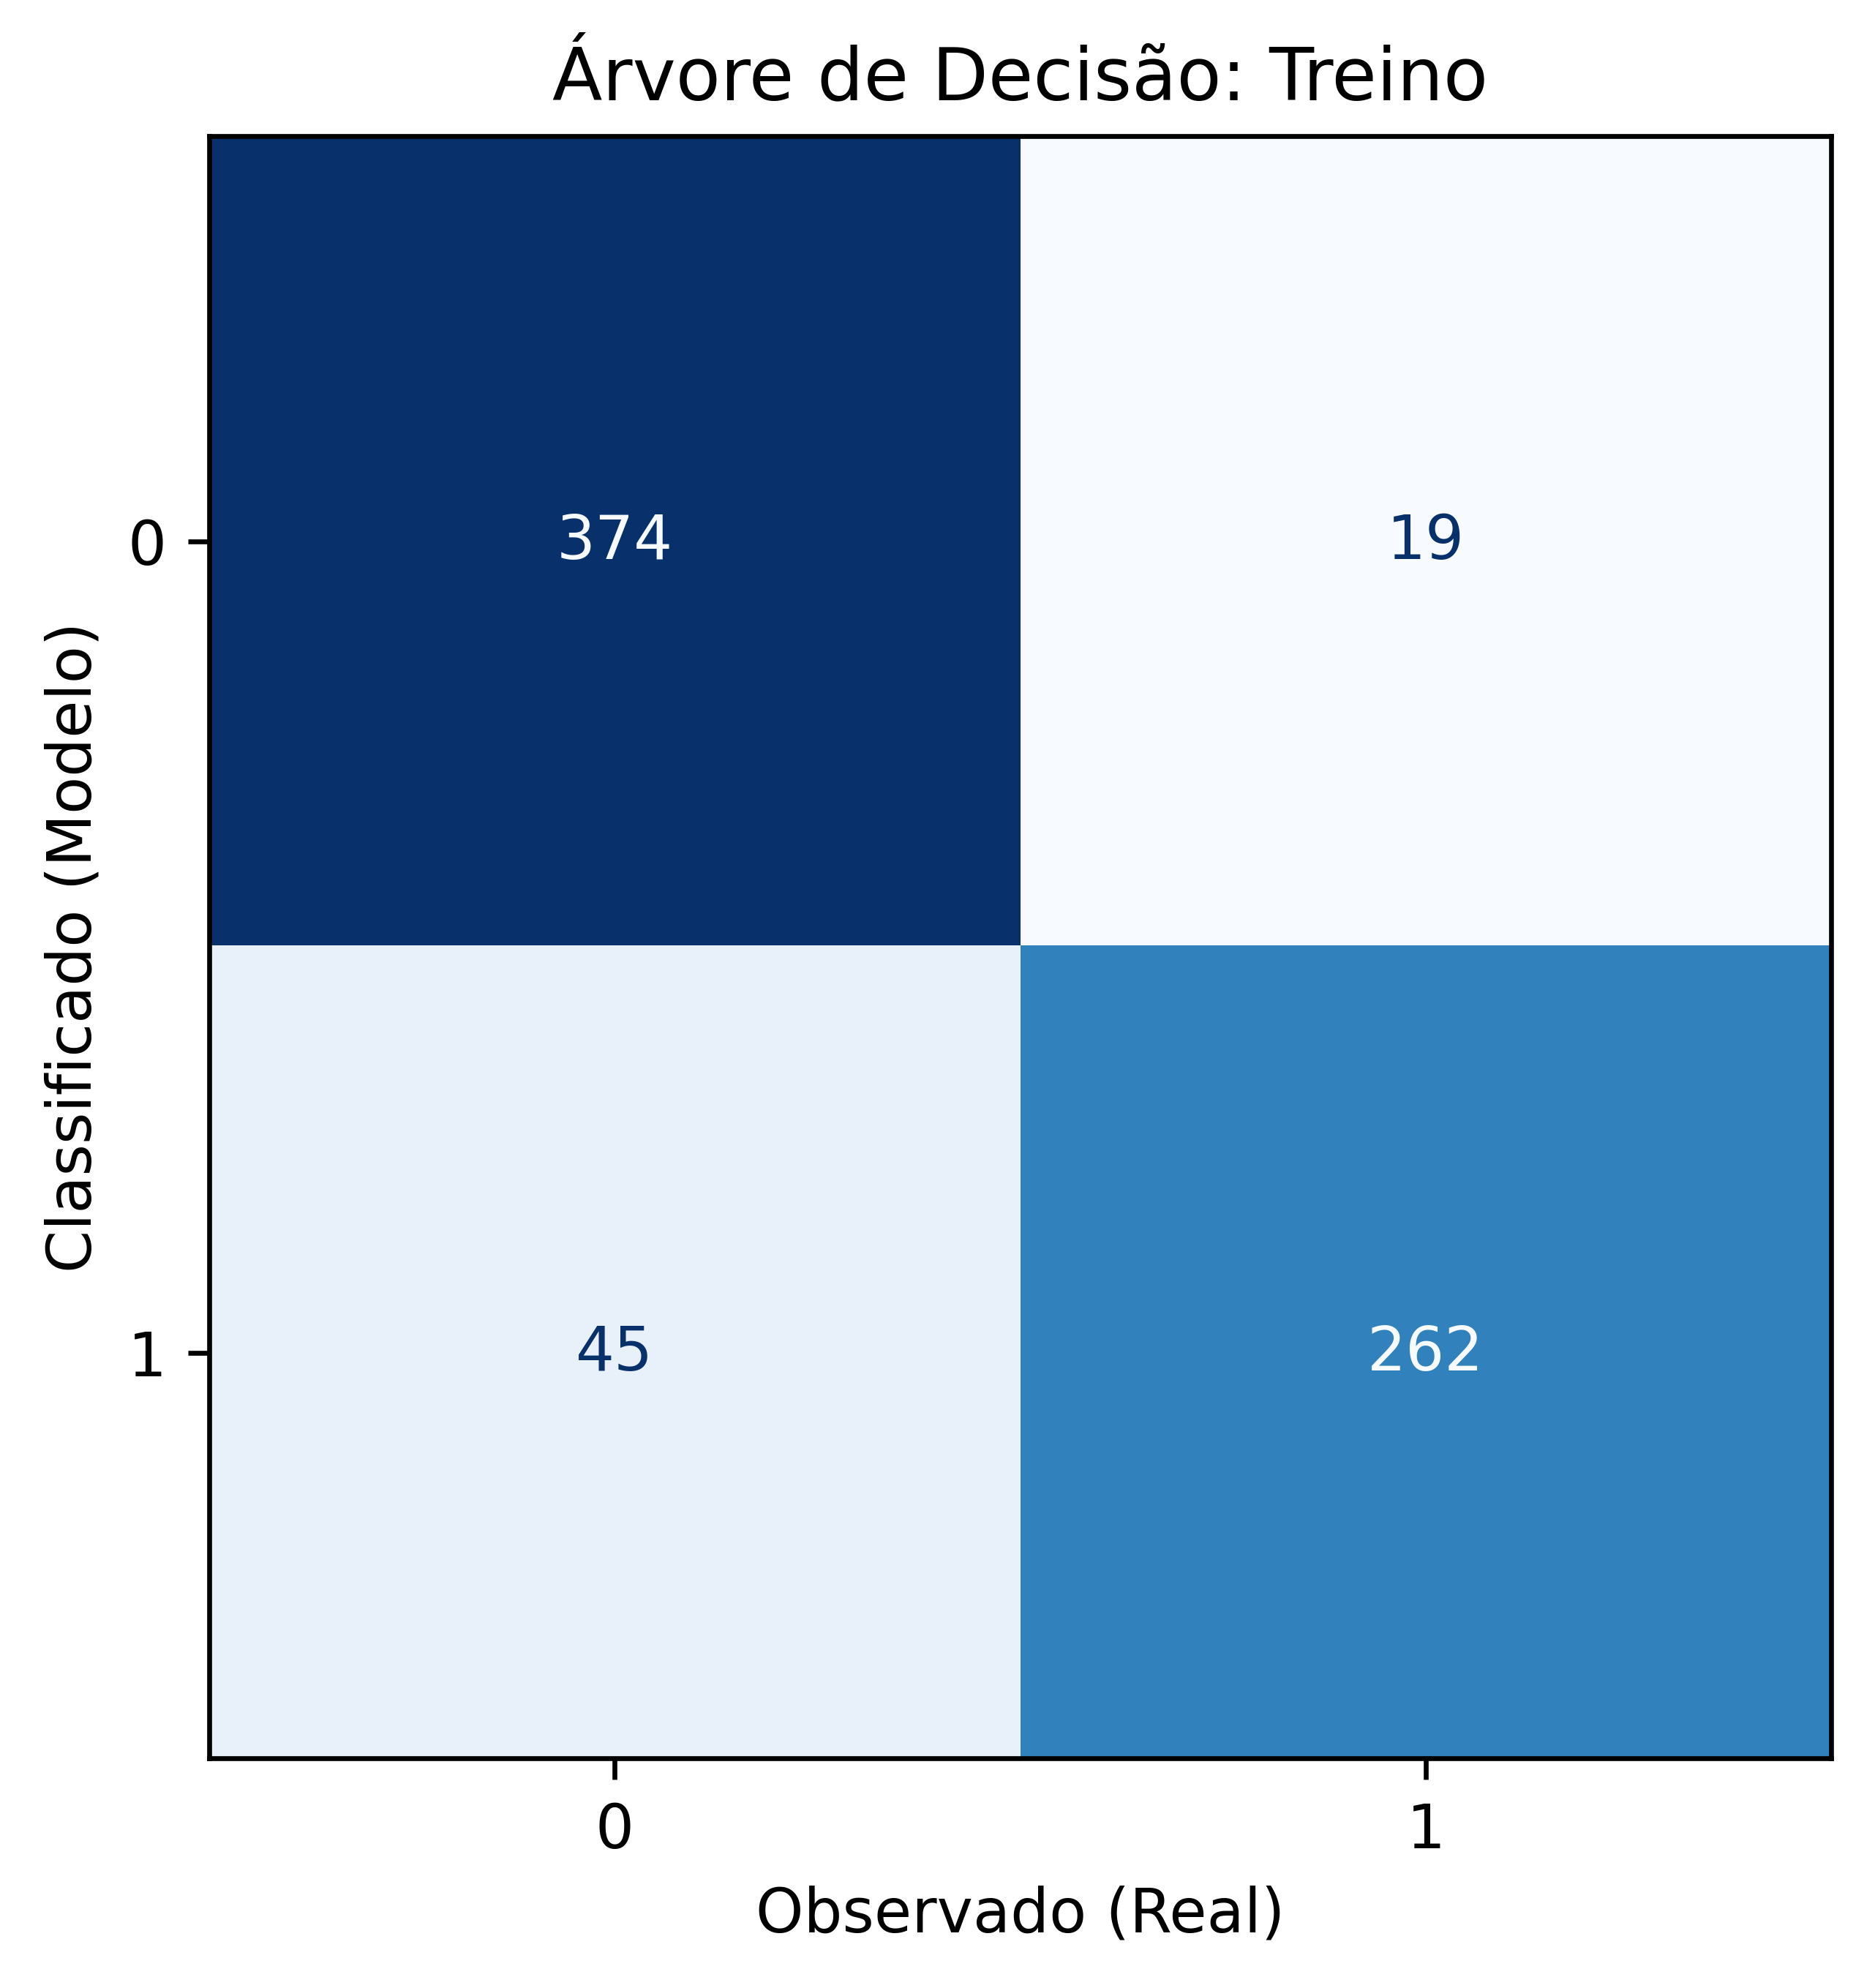

In [16]:
# Matriz de confusão (base de treino)

tree_cm_train = confusion_matrix(tree_pred_train_class, y_train)
cm_train_disp_tree = ConfusionMatrixDisplay(tree_cm_train)

plt.rcParams['figure.dpi'] = 600
cm_train_disp_tree.plot(colorbar=False, cmap='Blues')
plt.title('Árvore de Decisão: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()


In [17]:

acc_tree_train = accuracy_score(y_train, tree_pred_train_class)
sens_tree_train = recall_score(y_train, tree_pred_train_class, pos_label=1)
espec_tree_train = recall_score(y_train, tree_pred_train_class, pos_label=0)
prec_tree_train = precision_score(y_train, tree_pred_train_class)

print("Avaliação da Árvore (Base de Treino)")
print(f"Acurácia: {acc_tree_train:.1%}")
print(f"Sensibilidade: {sens_tree_train:.1%}")
print(f"Especificidade: {espec_tree_train:.1%}")
print(f"Precision: {prec_tree_train:.1%}")

Avaliação da Árvore (Base de Treino)
Acurácia: 90.9%
Sensibilidade: 93.2%
Especificidade: 89.3%
Precision: 85.3%


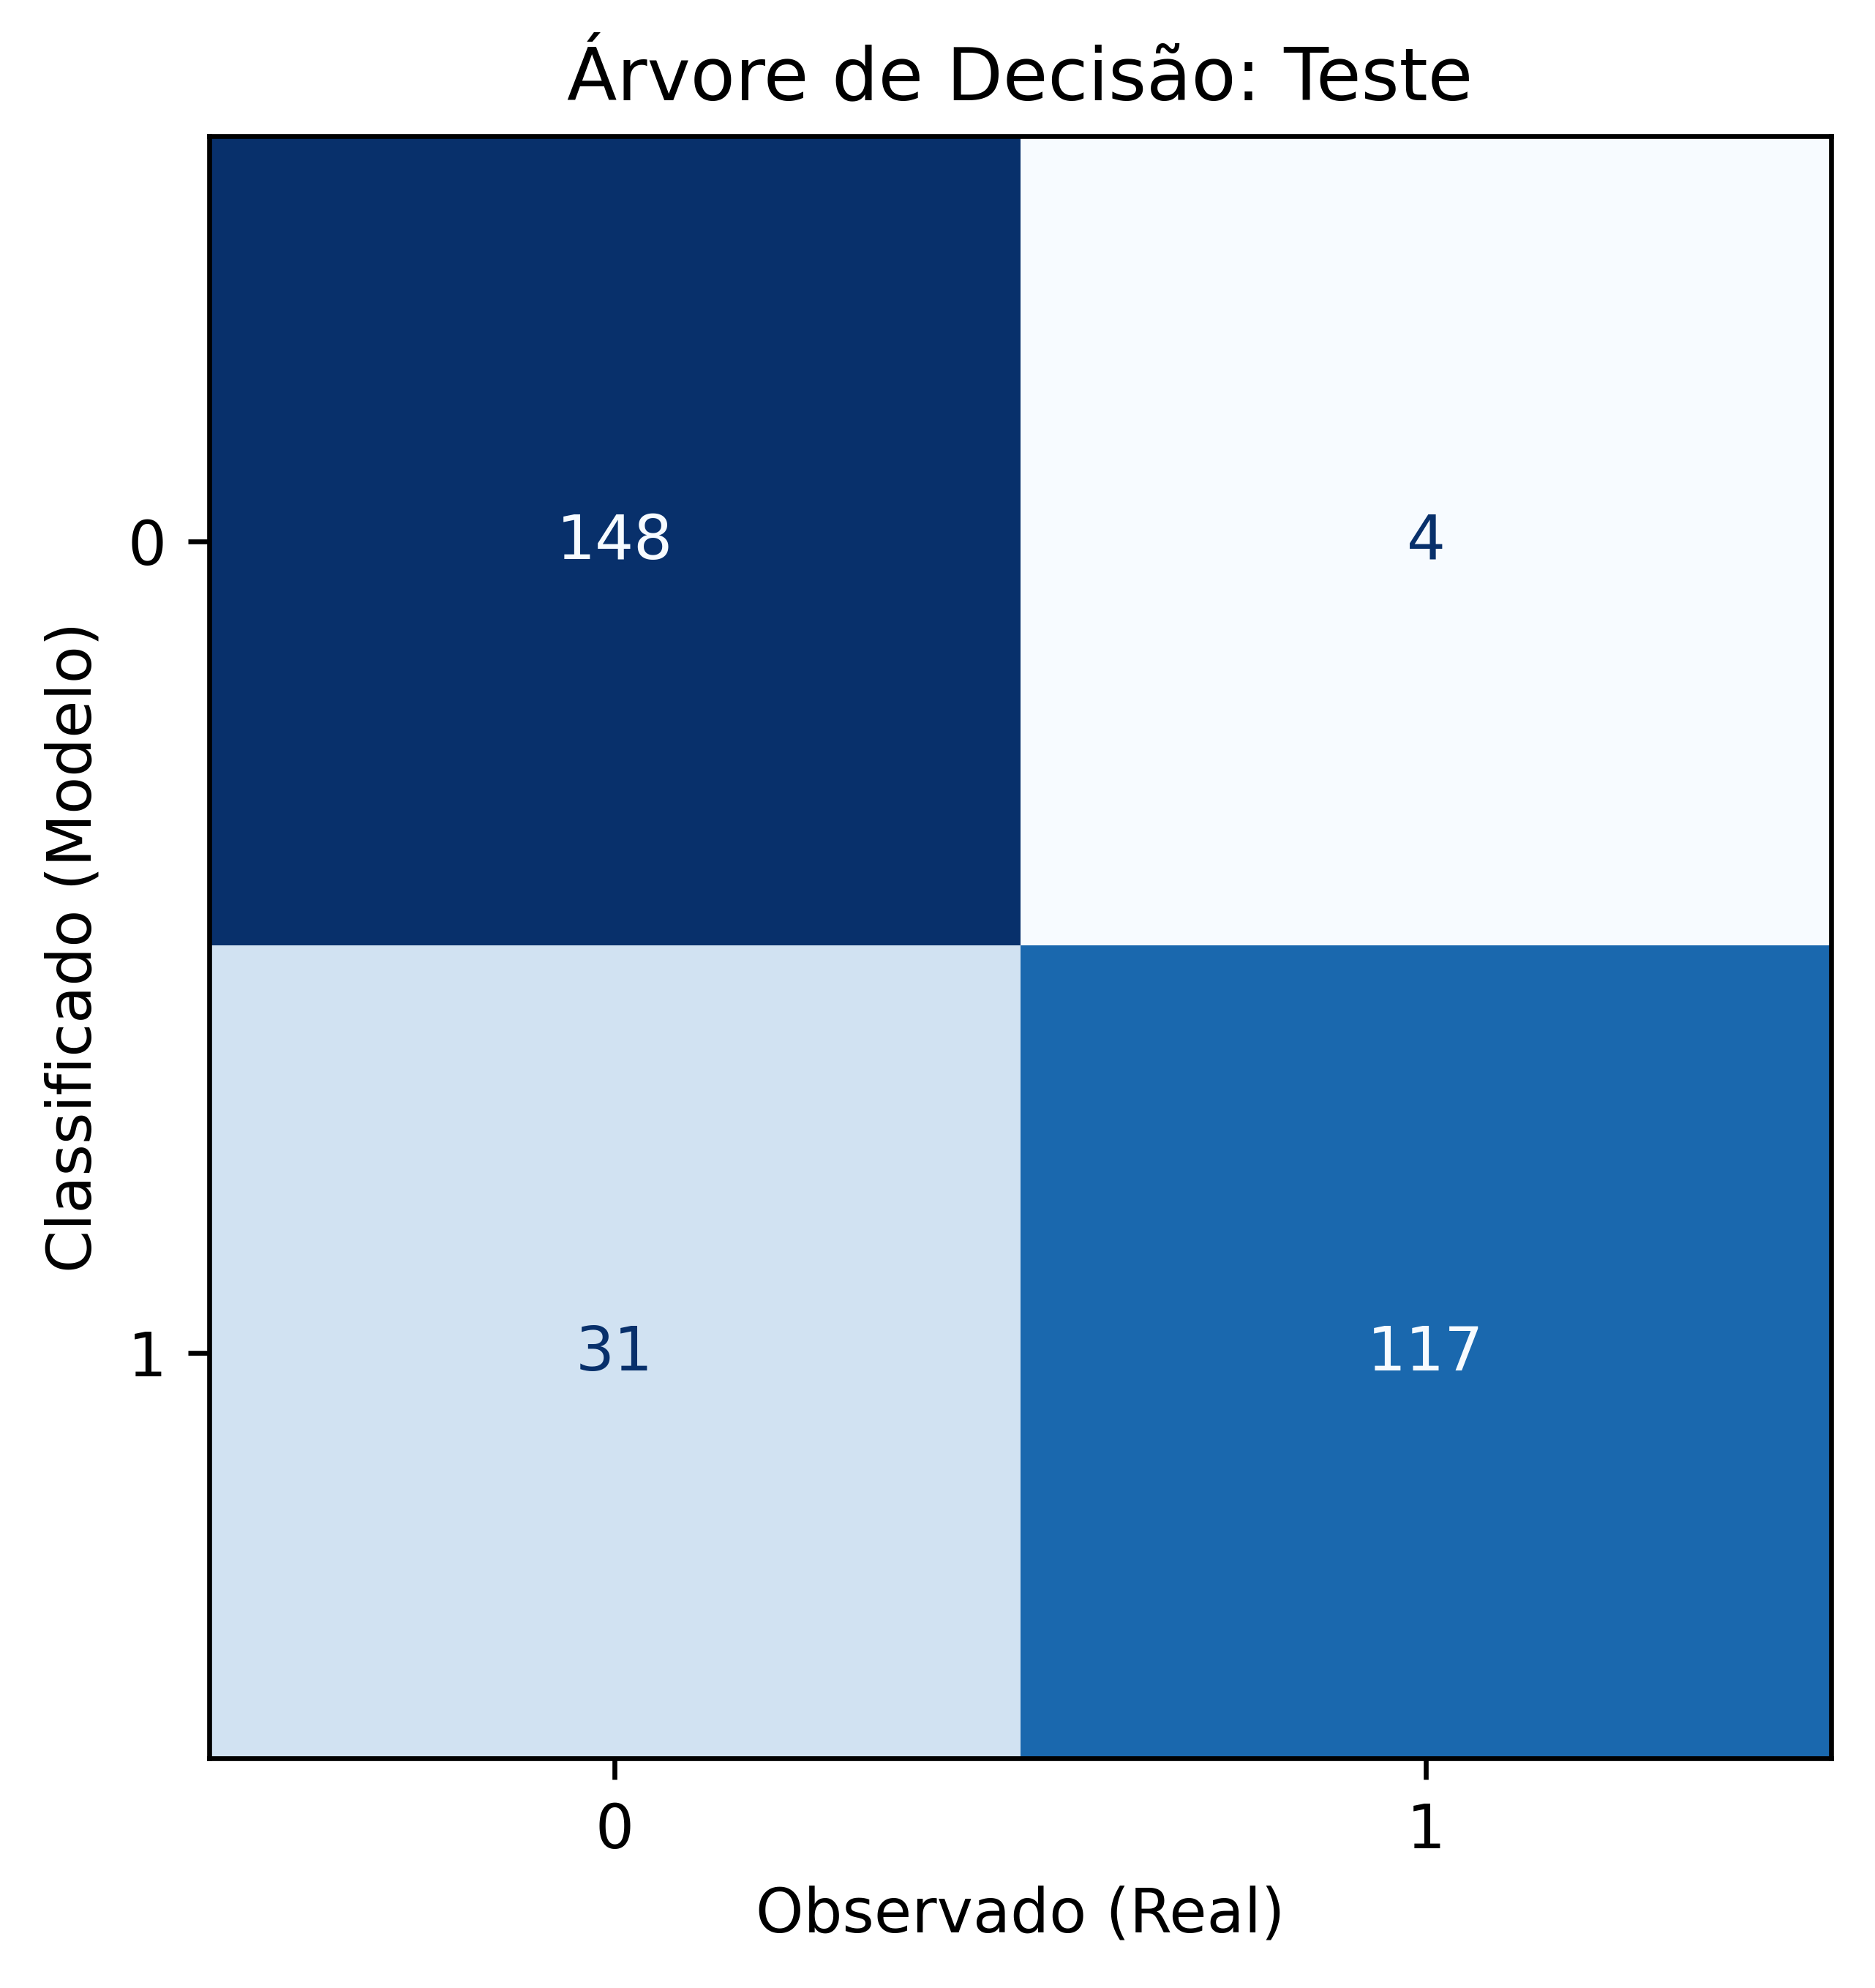

Avaliação da Árvore (Base de Teste)
Acurácia: 88.3%
Sensibilidade: 96.7%
Especificidade: 82.7%
Precision: 79.1%


In [18]:
#%% Matriz de confusão (base de teste)

tree_cm_test = confusion_matrix(tree_pred_test_class, y_test)
cm_test_disp_tree = ConfusionMatrixDisplay(tree_cm_test)

plt.rcParams['figure.dpi'] = 600
cm_test_disp_tree.plot(colorbar=False, cmap='Blues')
plt.title('Árvore de Decisão: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_tree_test = accuracy_score(y_test, tree_pred_test_class)
sens_tree_test = recall_score(y_test, tree_pred_test_class, pos_label=1)
espec_tree_test = recall_score(y_test, tree_pred_test_class, pos_label=0)
prec_tree_test = precision_score(y_test, tree_pred_test_class)

print("Avaliação da Árvore (Base de Teste)")
print(f"Acurácia: {acc_tree_test:.1%}")
print(f"Sensibilidade: {sens_tree_test:.1%}")
print(f"Especificidade: {espec_tree_test:.1%}")
print(f"Precision: {prec_tree_test:.1%}")



In [19]:
#%% Alguns hiperparâmetros do modelo

# max_depth: profundidade máxima da árvore
# min_samples_split: qtde mínima de observações exigidas para dividir o nó
# min_samples_leaf: qtde mínima de observações exigidas para ser nó folha

tree_clf_aj = DecisionTreeClassifier(max_depth=7,
                                     min_samples_split=10,
                                     min_samples_leaf=5,
                                     random_state=100)
tree_clf_aj.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=10,
                       random_state=100)

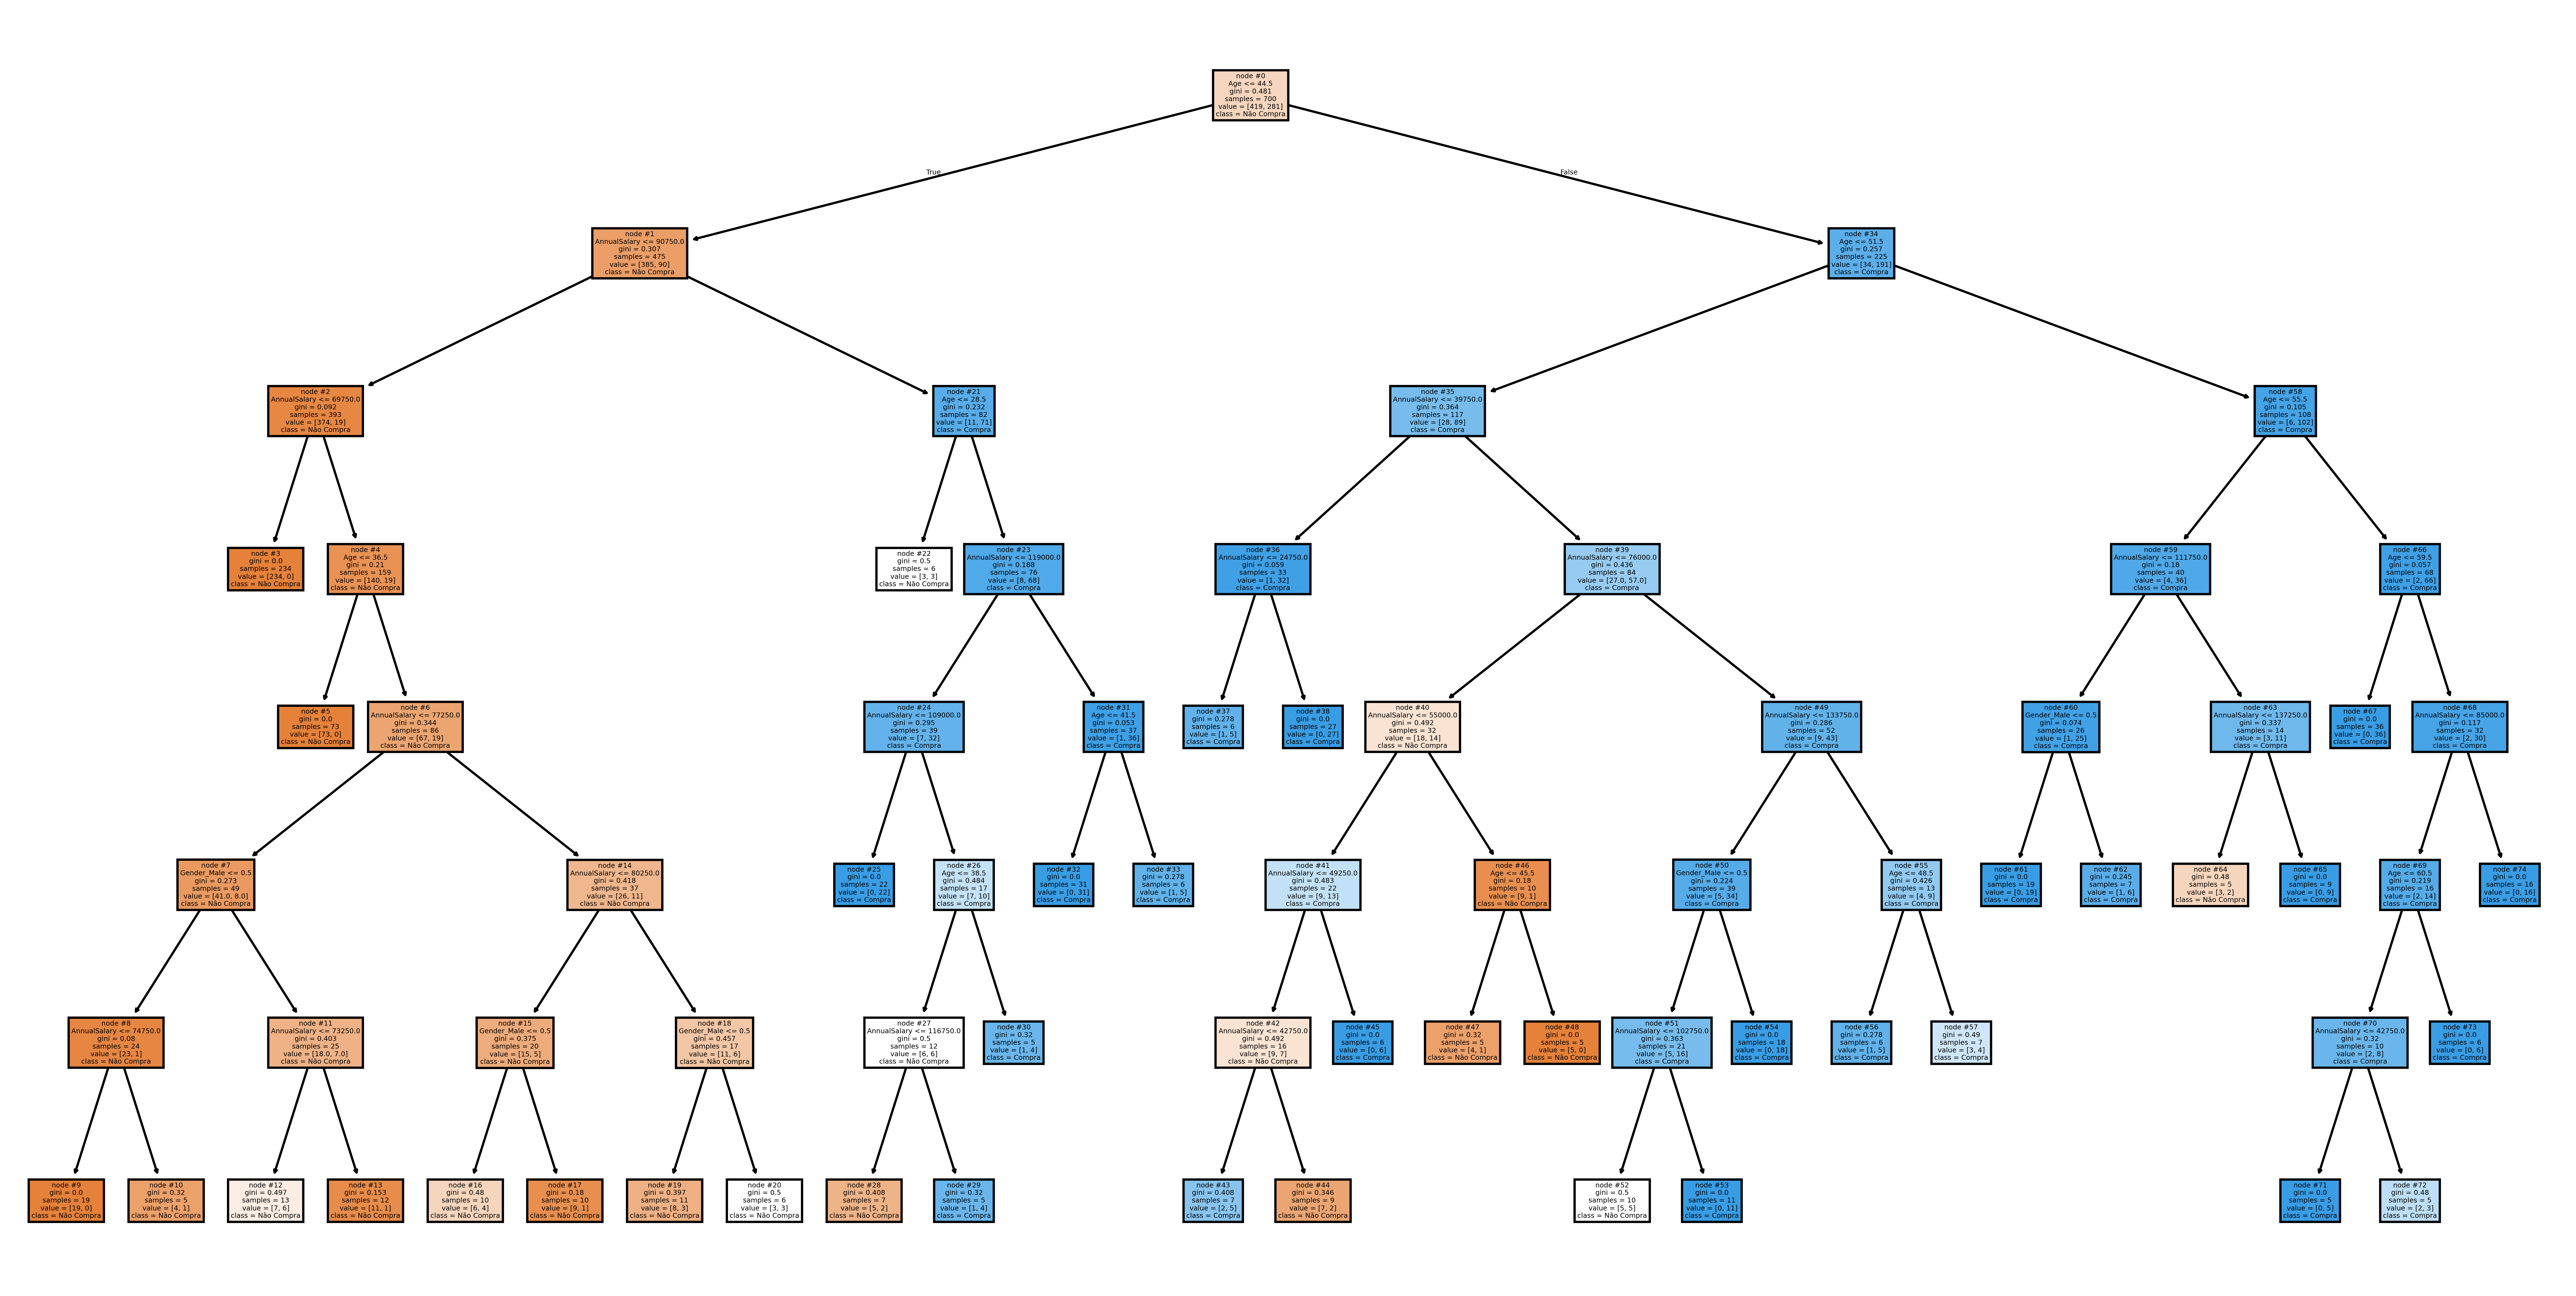

In [20]:
#%% Plotando a árvore ajustada

plt.figure(figsize=(20,10), dpi=600)
plot_tree(tree_clf_aj,
          feature_names=X.columns.tolist(),
          class_names=['Não Compra','Compra'],
          proportion=False,
          filled=True,
          node_ids=True)
plt.show()


In [21]:
# Obtendo os valores preditos pelo modelo ajustado (base de teste)

tree_pred_test_class_aj = tree_clf_aj.predict(X_test)
tree_pred_test_prob_aj = tree_clf_aj.predict_proba(X_test)




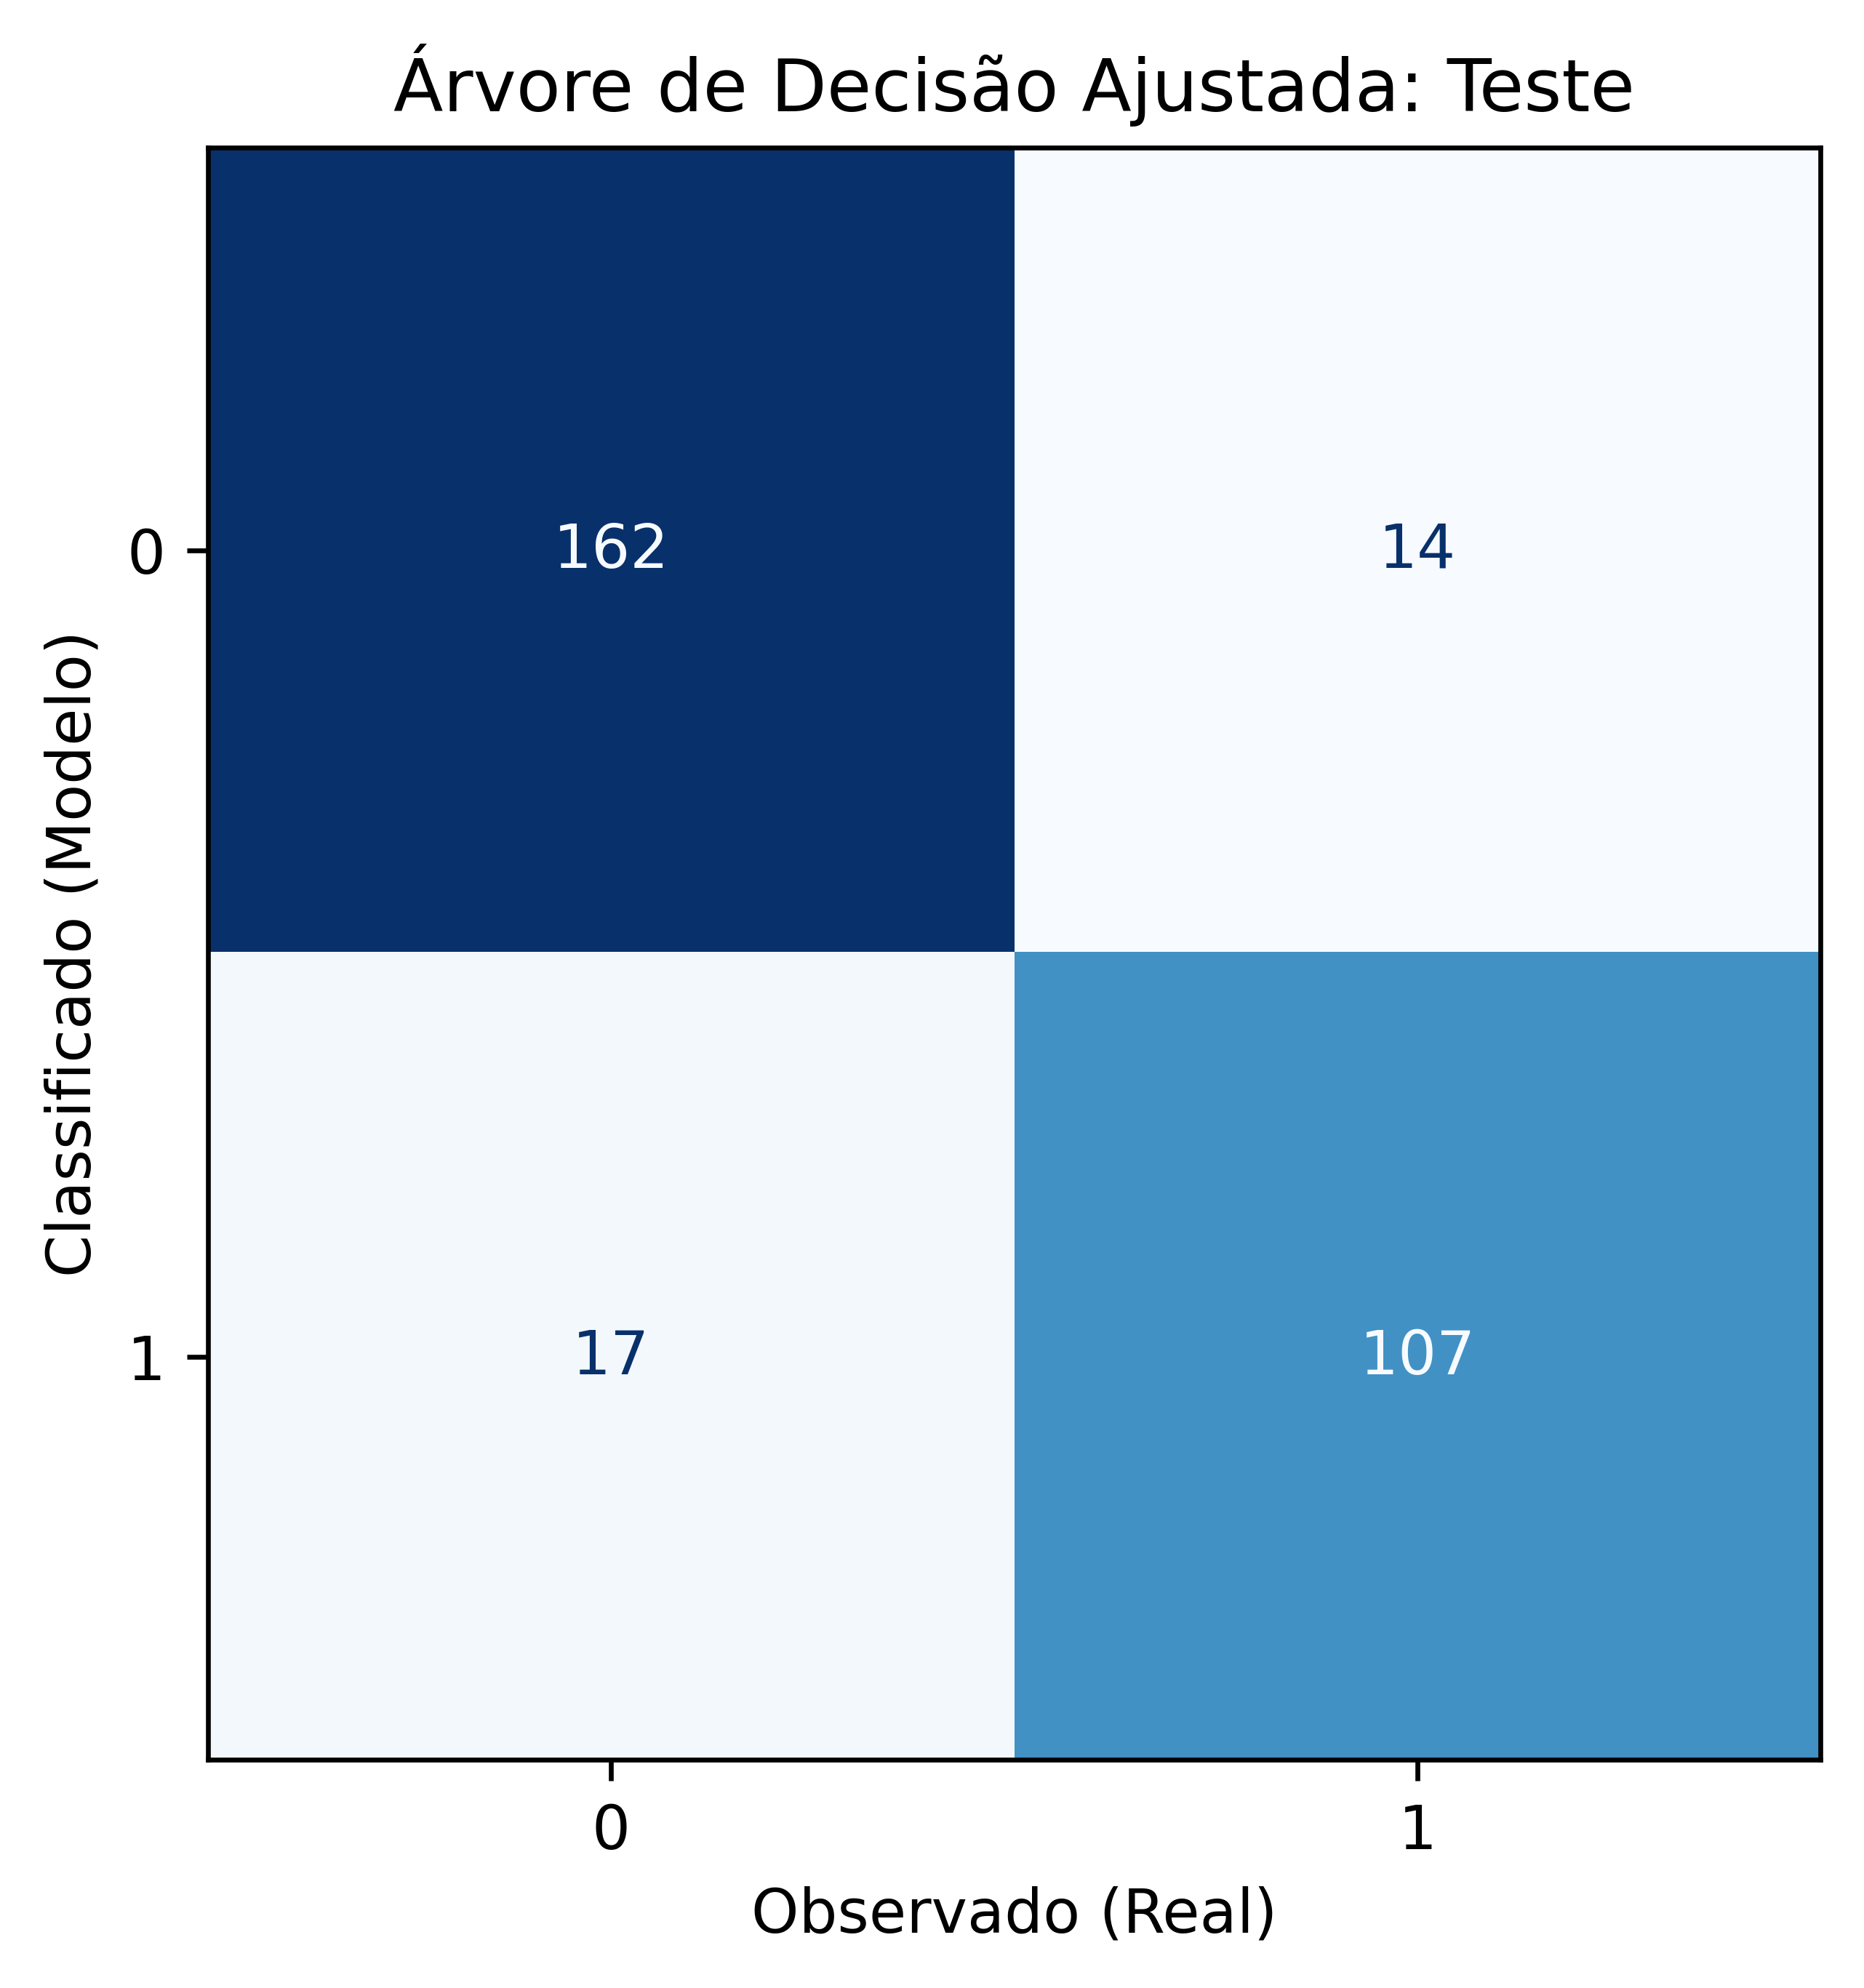

Avaliação da Árvore Ajustada (Base de Teste)
Acurácia: 89.7%
Sensibilidade: 88.4%
Especificidade: 90.5%
Precision: 86.3%


In [22]:
# Matriz de confusão (base de teste)
tree_cm_test_aj = confusion_matrix(tree_pred_test_class_aj, y_test)
cm_test_disp_aj = ConfusionMatrixDisplay(tree_cm_test_aj)

plt.rcParams['figure.dpi'] = 600
cm_test_disp_aj.plot(colorbar=False, cmap='Blues')
plt.title('Árvore de Decisão Ajustada: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_tree_test_aj = accuracy_score(y_test, tree_pred_test_class_aj)
sens_tree_test_aj = recall_score(y_test, tree_pred_test_class_aj, pos_label=1)
espec_tree_test_aj = recall_score(y_test, tree_pred_test_class_aj, pos_label=0)
prec_tree_test_aj = precision_score(y_test, tree_pred_test_class_aj)

print("Avaliação da Árvore Ajustada (Base de Teste)")
print(f"Acurácia: {acc_tree_test_aj:.1%}")
print(f"Sensibilidade: {sens_tree_test_aj:.1%}")
print(f"Especificidade: {espec_tree_test_aj:.1%}")
print(f"Precision: {prec_tree_test_aj:.1%}")



In [23]:
## Não há melhoria expressiva em relação à árvore menor!

#%% Curva ROC (base de teste)

# Parametrizando a função da curva ROC (real vs. previsto)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, tree_pred_test_prob_aj[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)

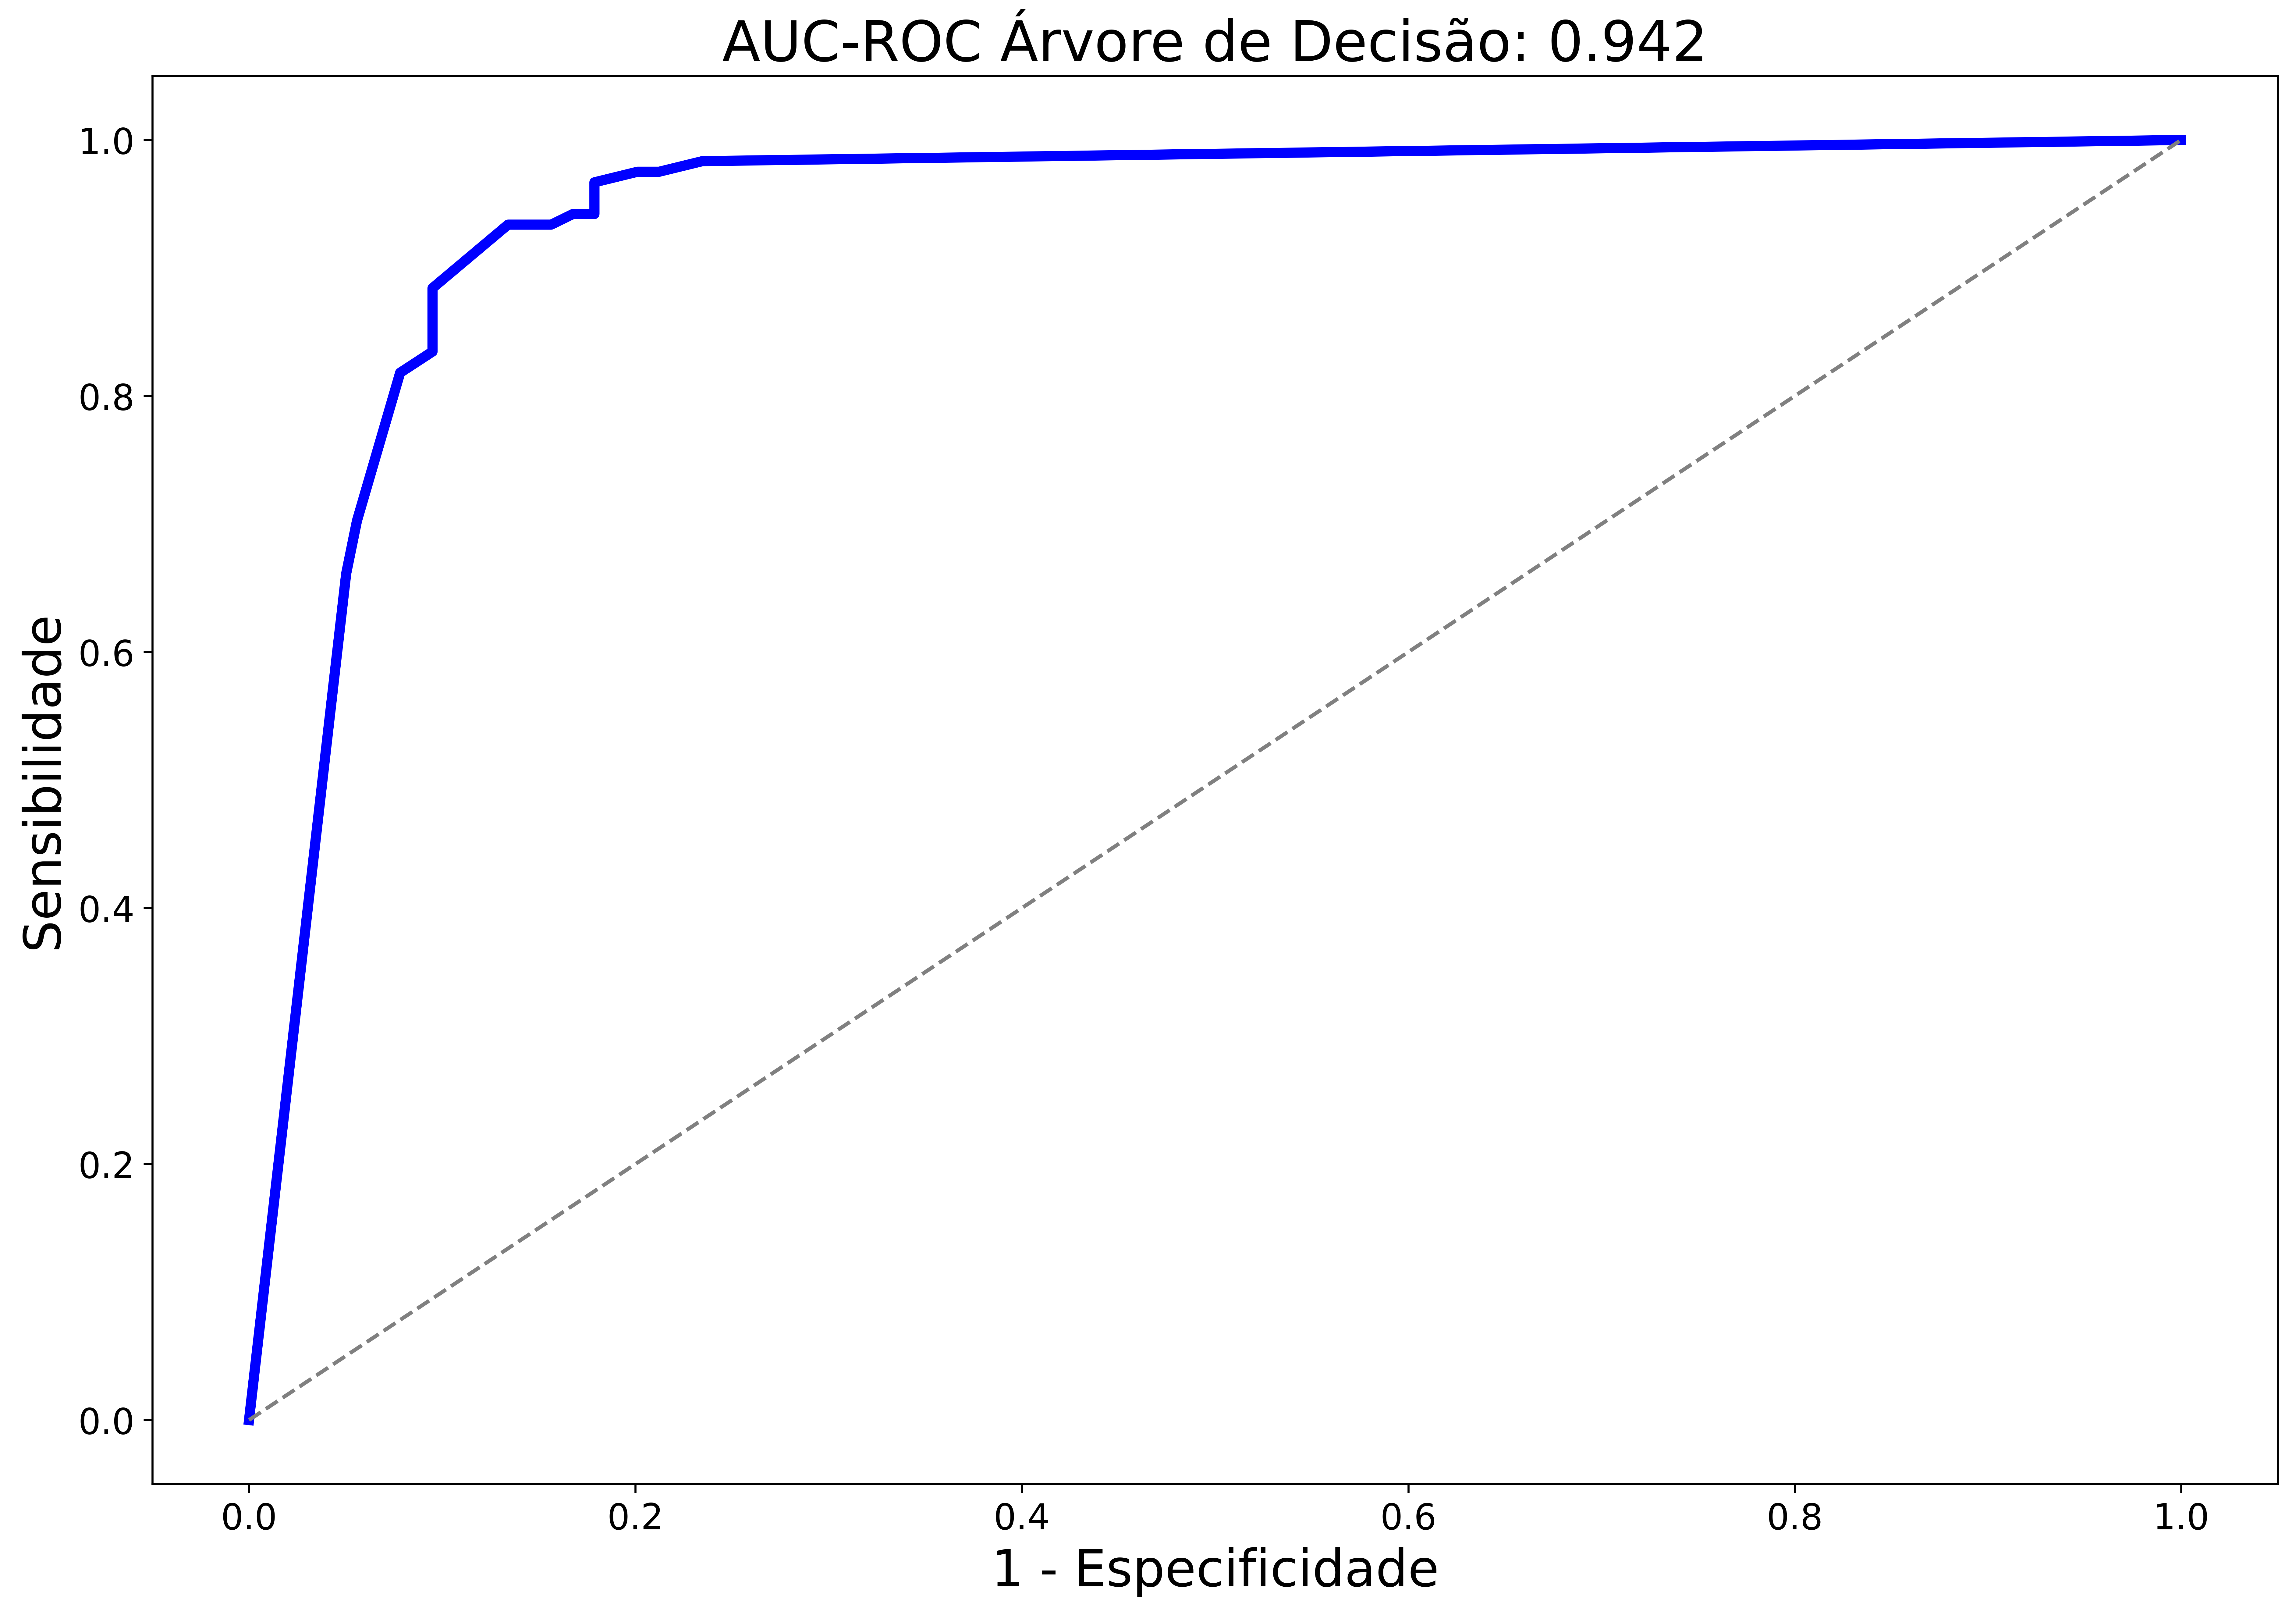

In [24]:
# Plotando a curva ROC
plt.figure(figsize=(15,10), dpi=600)
plt.plot(fpr_tree, tpr_tree, color='blue', linewidth=4)
plt.plot(fpr_tree, fpr_tree, color='gray', linestyle='dashed')
plt.title('AUC-ROC Árvore de Decisão: %g' % round(roc_auc_tree, 3), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()